In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def stochastic_env(u, a):
    #print(u)
    #print(a)
    if u==1:
        if a==0:
            r = 1
            next_u = 0
        elif a==1:
            r = 2
            next_u = 0
        elif a==2:
            r = -1
            if np.random.rand() <= 0.5:
                next_u = 2
            else:
                next_u = 3
    elif u==2:
        if a==0:
            r = 8
            next_u = 0
        elif a==1:
            r = -8
            next_u = 0
    elif u==3:
        if a==0:
            r = 0
            next_u = 0
        elif a==1:
            r = 4
            next_u = 0
        
    return next_u, r

In [18]:
def eval_trial(v, lr):
    u1 = 1
    p = np.random.rand()
    a1 = int(p*3)
    u2, r1 = stochastic_env(u1, a1)
    TD = r1 + v[u2] - v[u1]
    v[u1] += lr*TD
    if u2:
        a2 = 0 if np.random.rand() <= 0.5 else 1
        u3, r2 = stochastic_env(u2, a2)
        TD = r2 + v[u3] - v[u2]
        v[u2] += lr*TD
        
    return v

In [19]:
def eval_simulation(lr, n_trials, repeat):
    V_avg = np.zeros((n_trials, 4))
    for i in range(repeat):
        V = np.zeros((n_trials, 4))
        for t in range(n_trials-1):
            V[t+1] = eval_trial(V[t], lr)
        V_avg+=V
    
    V_avg /= repeat
    return V, V_avg

In [20]:
lr = 0.2
n_trials = 1000
repeat = 100
V, V_avg = eval_simulation(lr, n_trials, repeat)

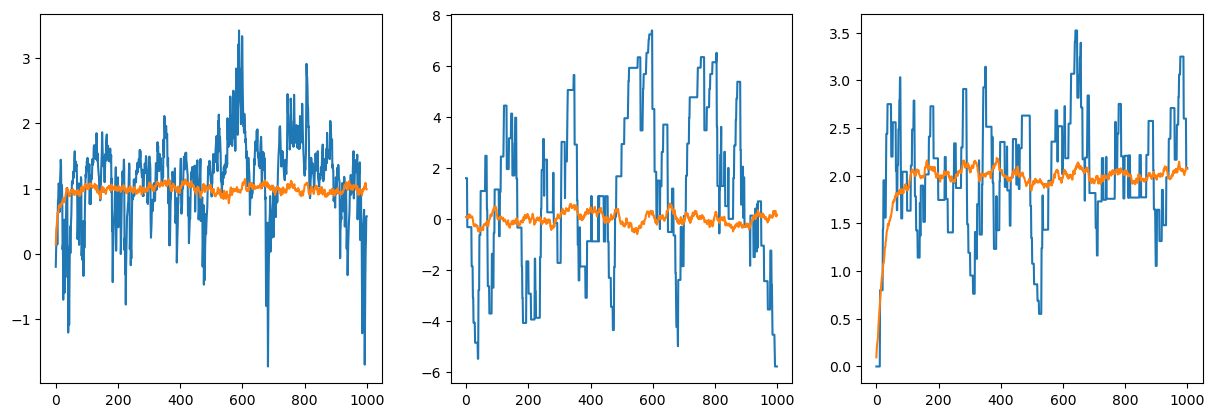

In [21]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(15)
x = np.arange(n_trials)

axs[0].plot(x, V[:, 1])
axs[0].plot(x, V_avg[:, 1])

axs[1].plot(x, V[:, 2])
axs[1].plot(x, V_avg[:, 2])

axs[2].plot(x, V[:, 3])
axs[2].plot(x, V_avg[:, 3])

plt.show()

# actor-critic

In [22]:
def softmax(m):
    ex = np.exp(temp * m)
    p = ex/np.sum(ex)
    
    return p
    

In [46]:
def ac_trial(env, M, V, P, lr, lr_a, decay, t):
    V[t+1] = V[t] 
    for i in [1,2,3]:
        M[i][t+1] = M[i][t]
        P[i][t] = softmax(M[i][t])    
        
    u1 = 1  
    a1 = np.random.choice(len(P[u1][t]), 1, p = P[u1][t])    
    
    u2, r1 = env(u1, a1)
    TD = r1 + V[t, u2] - V[t, u1]

    V[t+1, u1] += lr*TD
    M[u1][t+1] = M[u1][t] * (1-decay)
    M[u1][t+1,a1] += lr_a*TD
    
        
    if u2:
        a2 = np.random.choice(len(P[u2][t]), 1, p = P[u2][t])
        u3, r2 = env(u2, a2)       
        TD = r2 + V[t, u3] - V[t, u2]
        
        V[t+1, u2] += lr*TD
        M[u2][t+1] = M[u2][t] * (1-decay)
        M[u2][t+1,a2] += lr_a*TD
      
        
        
    return M, V, P

In [24]:
def ac_simulation(env, lr, lr_a, decay, n_trials, repeat): 
    V_avg = np.zeros((n_trials, 4))
    P_avg = [-1, np.zeros((n_trials, 3)) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
    for i in range(repeat):
        V = np.zeros((n_trials, 4))
        M = [-1, np.zeros((n_trials, 3), dtype=np.float64) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
        P = [-1, np.zeros((n_trials, 3)) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
        for t in range(n_trials-1):
            M, V, P = ac_trial(env, M, V, P, lr, lr_a, decay, t)
        
        V_avg+=V
        P_avg = [P_avg[i]+P[i] for i in range(4)]
    
    V_avg /= repeat
    P_avg = [P_avg[i] / repeat for i in range(4)]
    
    return M, V, P, V_avg, P_avg

In [25]:
lr = 0.2
lr_a = 0.075
decay = 1e-3
n_trials = 1000
repeat = 100
temp = 1

M, V, P, V_avg, P_avg = ac_simulation(stochastic_env, lr, lr_a,decay, n_trials, repeat)

In [26]:
def plotVP(n_trials, V, P, V_avg, P_avg):    
    fig, axs = plt.subplots(2,3)
    fig.set_figwidth(15)
    x = np.arange(n_trials)

    axs[0,0].plot(x, V[:, 1])
    axs[0,0].plot(x, V_avg[:, 1])

    axs[0,1].plot(x, V[:, 2])
    axs[0,1].plot(x, V_avg[:, 2])

    axs[0,2].plot(x, V[:, 3])
    axs[0,2].plot(x, V_avg[:, 3])

    axs[1,0].plot(x[:-1], P_avg[1][:-1, 0])
    axs[1,0].plot(x[:-1], P_avg[1][:-1, 1])
    axs[1,0].plot(x[:-1], P_avg[1][:-1, 2], color = 'green')

    axs[1,1].plot(x[:-1], P_avg[2][:-1, 0])
    axs[1,1].plot(x[:-1], P_avg[2][:-1, 1])

    axs[1,2].plot(x[:-1], P_avg[3][:-1, 0])
    axs[1,2].plot(x[:-1], P_avg[3][:-1, 1])

    plt.show()

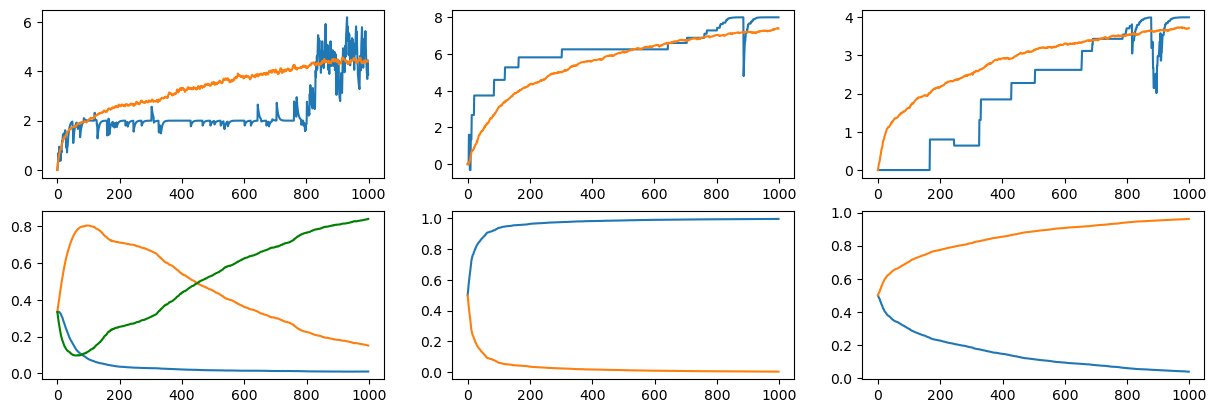

In [27]:
plotVP(n_trials, V, P, V_avg, P_avg)

In [29]:
lr = 0.2
lr_a = 0.075
decay = 1e-3
n_trials = 1000
repeat = 100
temp = 0.1

M, V, P, V_avg, P_avg = ac_simulation(stochastic_env, lr, lr_a,decay, n_trials, repeat)

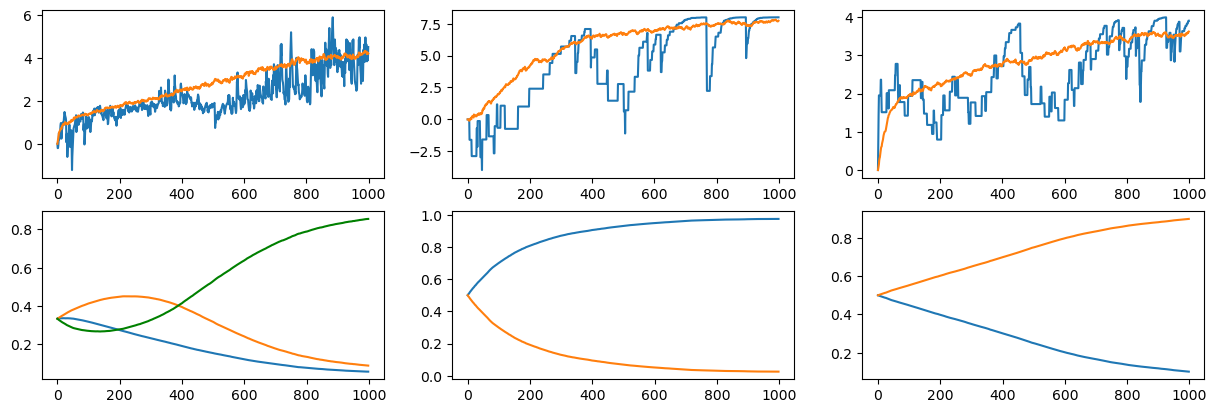

In [30]:
plotVP(n_trials, V, P, V_avg, P_avg)

In [31]:
lr = 0.2
lr_a = 0.15
decay = 1e-3
n_trials = 1000
repeat = 100
temp = 1

M, V, P, V_avg, P_avg = ac_simulation(stochastic_env, lr, lr_a,decay, n_trials, repeat)

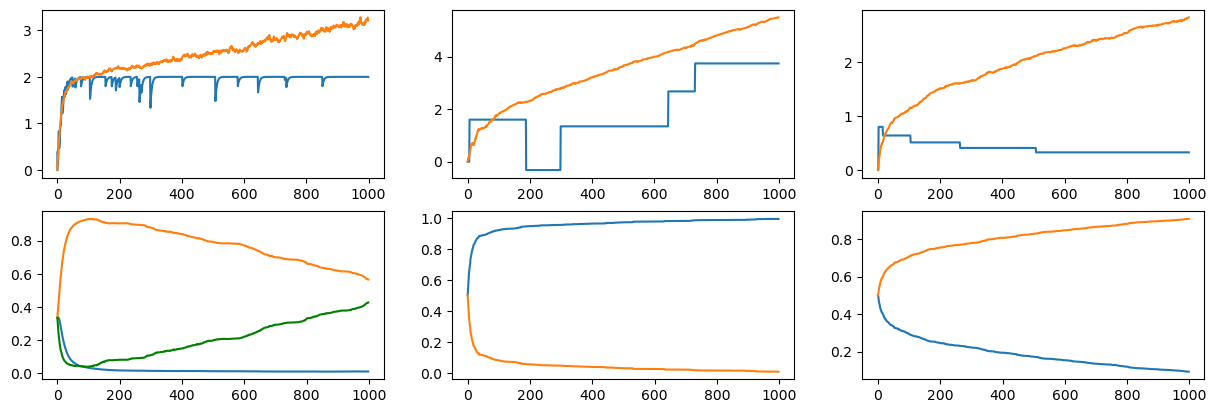

In [32]:
plotVP(n_trials, V, P, V_avg, P_avg)

In [33]:
def maze_env(u, a):
    #print(u)
    #print(a)
    if u==1:
        if a==0:
            r = 0
            next_u = 2
        elif a==1:
            r = 0
            next_u = 3

    elif u==2:
        if a==0:
            r = 4
            next_u = 0
        elif a==1:
            r = 0
            next_u = 0
            
    elif u==3:
        if a==0:
            r = 2
            next_u = 0
        elif a==1:
            r = 3
            next_u = 0
        
    return next_u, r

In [36]:
def maze_simulation(env, lr, lr_a, decay, n_trials, repeat): 
    V_avg = np.zeros((n_trials, 4))
    P_avg = [-1, np.zeros((n_trials, 2)) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
    for i in range(repeat):
        V = np.zeros((n_trials, 4))
        M = [-1, np.zeros((n_trials, 2), dtype=np.float64) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
        P = [-1, np.zeros((n_trials, 2)) , np.zeros((n_trials, 2)), np.zeros((n_trials, 2))]
        for t in range(n_trials-1):
            M, V, P = ac_trial(env, M, V, P, lr, lr_a, decay, t)
        
        V_avg+=V
        P_avg = [P_avg[i]+P[i] for i in range(4)]
    
    V_avg /= repeat
    P_avg = [P_avg[i] / repeat for i in range(4)]
    
    return M, V, P, V_avg, P_avg

In [47]:
lr = 0.2
lr_a = 0.075
decay = 1e-3
n_trials = 1000
repeat = 100
temp = 1

M, V, P, V_avg, P_avg = maze_simulation(maze_env, lr, lr_a,decay, n_trials, repeat)

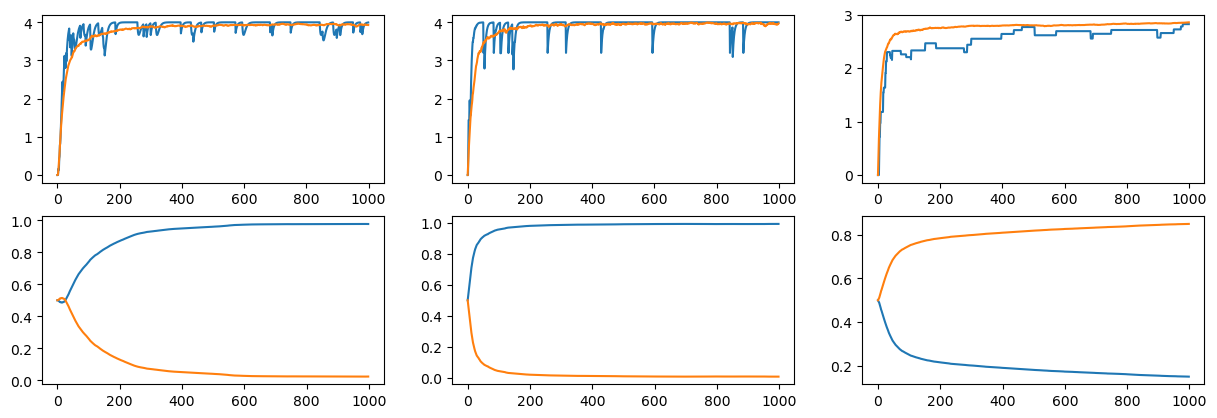

In [48]:
fig, axs = plt.subplots(2,3)
fig.set_figwidth(15)
x = np.arange(n_trials)

axs[0,0].plot(x, V[:, 1])
axs[0,0].plot(x, V_avg[:, 1])

axs[0,1].plot(x, V[:, 2])
axs[0,1].plot(x, V_avg[:, 2])

axs[0,2].plot(x, V[:, 3])
axs[0,2].plot(x, V_avg[:, 3])

axs[1,0].plot(x[:-1], P_avg[1][:-1, 0])
axs[1,0].plot(x[:-1], P_avg[1][:-1, 1])

axs[1,1].plot(x[:-1], P_avg[2][:-1, 0])
axs[1,1].plot(x[:-1], P_avg[2][:-1, 1])

axs[1,2].plot(x[:-1], P_avg[3][:-1, 0])
axs[1,2].plot(x[:-1], P_avg[3][:-1, 1])

plt.show()

In [55]:
lr = 0.2
lr_a = 0.075
decay = 1e-3
n_trials = 1000
repeat = 100
temp = 2

M, V, P, V_avg, P_avg = maze_simulation(maze_env, lr, lr_a,decay, n_trials, repeat)

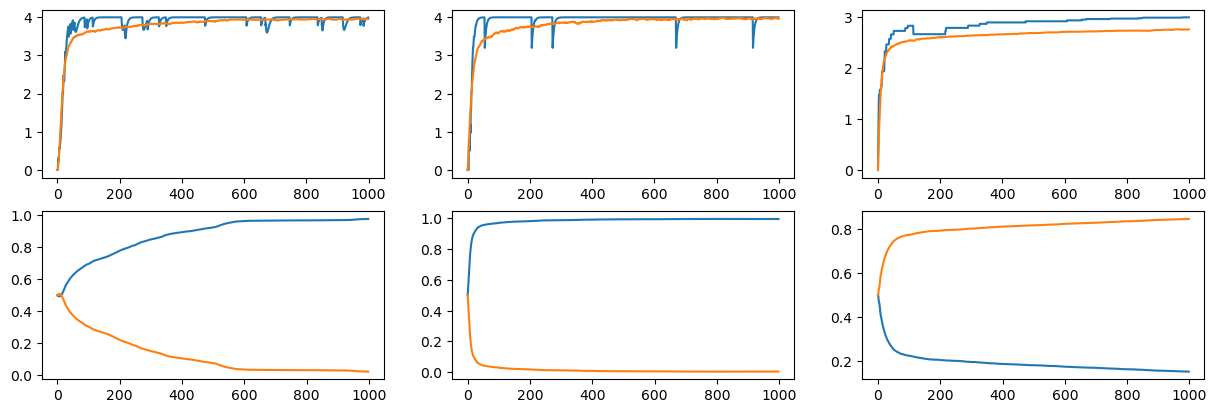

In [56]:
fig, axs = plt.subplots(2,3)
fig.set_figwidth(15)
x = np.arange(n_trials)

axs[0,0].plot(x, V[:, 1])
axs[0,0].plot(x, V_avg[:, 1])

axs[0,1].plot(x, V[:, 2])
axs[0,1].plot(x, V_avg[:, 2])

axs[0,2].plot(x, V[:, 3])
axs[0,2].plot(x, V_avg[:, 3])

axs[1,0].plot(x[:-1], P_avg[1][:-1, 0])
axs[1,0].plot(x[:-1], P_avg[1][:-1, 1])

axs[1,1].plot(x[:-1], P_avg[2][:-1, 0])
axs[1,1].plot(x[:-1], P_avg[2][:-1, 1])

axs[1,2].plot(x[:-1], P_avg[3][:-1, 0])
axs[1,2].plot(x[:-1], P_avg[3][:-1, 1])

plt.show()